In [1]:
# ==== Celda 1: imports, datos y ruido ====
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

# Datos base
cancer = load_breast_cancer()
X = cancer.data
y = cancer.target

# Añadimos ruido sintético (50 columnas) para emular el capítulo
rng = np.random.RandomState(42)
noise = rng.normal(size=(len(X), 50))

X_w_noise = np.hstack([X, noise])

# Nombres de columnas (30 reales + 50 ruido)
feature_names = list(cancer.feature_names) + [f"noise_{i}" for i in range(noise.shape[1])]

# Split (primero siempre)
X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, y, test_size=0.5, random_state=0, stratify=y
)

X_train.shape, X_test.shape


((284, 80), (285, 80))

In [2]:
# ==== Celda 2: helpers ====
import numpy as np

def plot_mask(mask, title="Máscara de selección"):
    plt.matshow(mask.reshape(1, -1), cmap="gray_r")
    plt.title(title)
    plt.xlabel("Índice de característica")
    plt.yticks([])
    plt.show()

def selected_names(mask, names):
    return [n for m, n in zip(mask, names) if m]


== Univariante (SelectPercentile) ==
Mejores params: {'clf__C': 10, 'select__percentile': 20}
CV best AUC:   0.991
Test AUC:      0.988


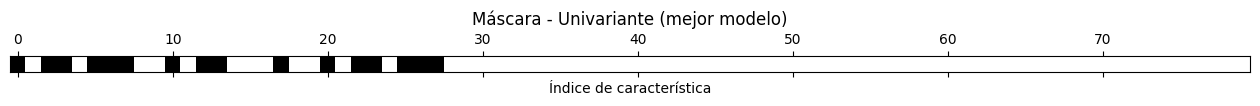

Features seleccionadas (univariante):
[np.str_('mean radius'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean compactness'), np.str_('mean concavity'), np.str_('mean concave points'), np.str_('radius error'), np.str_('perimeter error'), np.str_('area error'), np.str_('concave points error'), np.str_('worst radius'), np.str_('worst perimeter'), np.str_('worst area'), np.str_('worst compactness'), np.str_('worst concavity'), np.str_('worst concave points')]


In [3]:
# ==== Celda 3A: univariante (SelectPercentile) + LogisticRegression ====
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

pipe_uni = Pipeline(steps=[
    ("select", SelectPercentile(score_func=f_classif, percentile=50)),
    ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))
])

param_grid_uni = {
    "select__percentile": [5, 10, 20, 30, 50, 80, 100],
    "clf__C": [0.01, 0.1, 1, 10]
}

gs_uni = GridSearchCV(
    pipe_uni,
    param_grid_uni,
    scoring={"auc": "roc_auc", "acc": "accuracy"},
    refit="auc",
    cv=5,
    n_jobs=-1
)

gs_uni.fit(X_train, y_train)

print("== Univariante (SelectPercentile) ==")
print("Mejores params:", gs_uni.best_params_)
print("CV best AUC:   {:.3f}".format(gs_uni.best_score_))
print("Test AUC:      {:.3f}".format(gs_uni.score(X_test, y_test)))

# Extra: máscara y nombres seleccionados
best_uni_selector = gs_uni.best_estimator_.named_steps["select"]
mask_uni = best_uni_selector.get_support()
plot_mask(mask_uni, "Máscara - Univariante (mejor modelo)")
print("Features seleccionadas (univariante):")
print(selected_names(mask_uni, feature_names))


== Basado en modelo (SelectFromModel + RF) ==
Mejores params: {'clf__C': 10, 'select__threshold': 'mean'}
CV best AUC:   0.991
Test AUC:      0.988


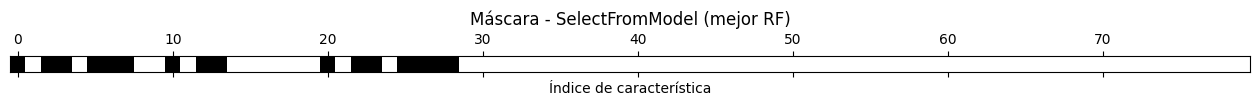

Features seleccionadas (SelectFromModel):
[np.str_('mean radius'), np.str_('mean perimeter'), np.str_('mean area'), np.str_('mean compactness'), np.str_('mean concavity'), np.str_('mean concave points'), np.str_('radius error'), np.str_('perimeter error'), np.str_('area error'), np.str_('worst radius'), np.str_('worst perimeter'), np.str_('worst area'), np.str_('worst compactness'), np.str_('worst concavity'), np.str_('worst concave points'), np.str_('worst symmetry')]


In [4]:
# ==== Celda 4A: SelectFromModel (RandomForest) + LogisticRegression ====
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier

pipe_sfm = Pipeline(steps=[
    ("select", SelectFromModel(
        estimator=RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
        threshold="median"
    )),
    ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))
])

# 'threshold' acepta "mean", "median" o expresiones tipo "1.5*mean"
param_grid_sfm = {
    "select__threshold": ["median", "mean", "0.5*mean", "1.5*median"],
    "clf__C": [0.01, 0.1, 1, 10]
}

gs_sfm = GridSearchCV(
    pipe_sfm,
    param_grid_sfm,
    scoring={"auc": "roc_auc", "acc": "accuracy"},
    refit="auc",
    cv=5,
    n_jobs=-1
)

gs_sfm.fit(X_train, y_train)

print("== Basado en modelo (SelectFromModel + RF) ==")
print("Mejores params:", gs_sfm.best_params_)
print("CV best AUC:   {:.3f}".format(gs_sfm.best_score_))
print("Test AUC:      {:.3f}".format(gs_sfm.score(X_test, y_test)))

best_sfm_selector = gs_sfm.best_estimator_.named_steps["select"]
mask_sfm = best_sfm_selector.get_support()
plot_mask(mask_sfm, "Máscara - SelectFromModel (mejor RF)")
print("Features seleccionadas (SelectFromModel):")
print(selected_names(mask_sfm, feature_names))


== RFE (con LR) ==
Mejores params: {'clf__C': 0.1, 'select__n_features_to_select': 60}
CV best AUC:   0.965
Test AUC:      0.953


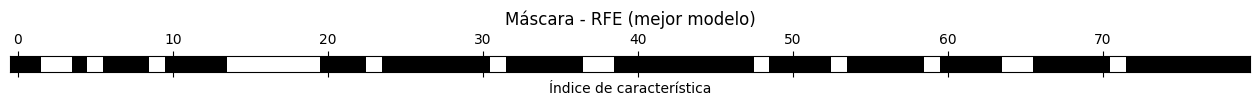

Features seleccionadas (RFE):
[np.str_('mean radius'), np.str_('mean texture'), np.str_('mean smoothness'), np.str_('mean concavity'), np.str_('mean concave points'), np.str_('mean symmetry'), np.str_('radius error'), np.str_('texture error'), np.str_('perimeter error'), np.str_('area error'), np.str_('worst radius'), np.str_('worst texture'), np.str_('worst perimeter'), np.str_('worst smoothness'), np.str_('worst compactness'), np.str_('worst concavity'), np.str_('worst concave points'), np.str_('worst symmetry'), np.str_('worst fractal dimension'), 'noise_0', 'noise_2', 'noise_3', 'noise_4', 'noise_5', 'noise_6', 'noise_9', 'noise_10', 'noise_11', 'noise_12', 'noise_13', 'noise_14', 'noise_15', 'noise_16', 'noise_17', 'noise_19', 'noise_20', 'noise_21', 'noise_22', 'noise_24', 'noise_25', 'noise_26', 'noise_27', 'noise_28', 'noise_30', 'noise_31', 'noise_32', 'noise_33', 'noise_36', 'noise_37', 'noise_38', 'noise_39', 'noise_40', 'noise_42', 'noise_43', 'noise_44', 'noise_45', 'noise

In [5]:
# ==== Celda 5A: RFE + LogisticRegression ====
from sklearn.feature_selection import RFE

# Usamos un estimador lineal estable y rápido para RFE
base_lr = LogisticRegression(max_iter=2000, solver="liblinear")

pipe_rfe = Pipeline(steps=[
    ("select", RFE(estimator=base_lr, n_features_to_select=30, step=0.1)),
    ("clf", LogisticRegression(max_iter=2000, solver="liblinear"))
])

param_grid_rfe = {
    "select__n_features_to_select": [10, 20, 30, 40, 60],
    "clf__C": [0.01, 0.1, 1, 10]
}

gs_rfe = GridSearchCV(
    pipe_rfe,
    param_grid_rfe,
    scoring={"auc": "roc_auc", "acc": "accuracy"},
    refit="auc",
    cv=5,
    n_jobs=-1
)

gs_rfe.fit(X_train, y_train)

print("== RFE (con LR) ==")
print("Mejores params:", gs_rfe.best_params_)
print("CV best AUC:   {:.3f}".format(gs_rfe.best_score_))
print("Test AUC:      {:.3f}".format(gs_rfe.score(X_test, y_test)))

best_rfe_selector = gs_rfe.best_estimator_.named_steps["select"]
mask_rfe = best_rfe_selector.get_support()
plot_mask(mask_rfe, "Máscara - RFE (mejor modelo)")
print("Features seleccionadas (RFE):")
print(selected_names(mask_rfe, feature_names))


In [6]:
# ==== Celda 6: baseline y resumen ====
from sklearn.metrics import roc_auc_score

baseline_lr = LogisticRegression(max_iter=2000, solver="liblinear").fit(X_train, y_train)
y_proba_base = baseline_lr.predict_proba(X_test)[:, 1]
baseline_auc = roc_auc_score(y_test, y_proba_base)

print("== Baseline (todas las features) ==")
print("Test AUC (LR sin selección): {:.3f}".format(baseline_auc))

print("\n== Resumen (AUC en test) ==")
print("Univariante  : {:.3f}".format(gs_uni.score(X_test, y_test)))
print("SFM (RF)     : {:.3f}".format(gs_sfm.score(X_test, y_test)))
print("RFE (LR)     : {:.3f}".format(gs_rfe.score(X_test, y_test)))
print("Baseline (LR): {:.3f}".format(baseline_auc))


== Baseline (todas las features) ==
Test AUC (LR sin selección): 0.979

== Resumen (AUC en test) ==
Univariante  : 0.988
SFM (RF)     : 0.988
RFE (LR)     : 0.953
Baseline (LR): 0.979
